# Recalculations, Plots, and Analysis of Data

In [1]:
from numpy import *
import astropy.units as u
from astropy.constants import G, M_jup, R_jup, M_earth, R_earth, L_sun, M_sun, R_sun
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import extinction as ex
import scipy.stats as st

## Functions:
Functions are in the python file functions.py. This cell imports the functions to this notebook.

In [2]:
import importlib, functions
importlib.reload(functions)
from functions import line_lum, accr_lum, acc_rate, get_rate

## Uniform scaling relations, new distances, new masses

In [3]:
#read in CSV
db = pd.read_csv('recalculations.csv')
tracers = ['Ha','PaB','BrG']

Recalculation:

In [4]:
#get accretion rates
#mass_used: one list of the masses used to recalculate accretion rate
mass_used = []

for i in db.index:  
    #use new distance, mass, and radius if it's available; else, use existing value
    d = db.loc[i,'Plx Distance']
    if isnan(d):
        d = db.loc[i,'Object Distance']
    R = db.loc[i,'Object Radius']
    M = db.loc[i,'New Mass']
    if isnan(M):
        M = db.loc[i,'Object Mass, Original']
        
    mass_used.append(M)

    #ignore if missing M or R
    if (isnan(M) or isnan(R)):
        continue
            
    for t in tracers:
        lf = db.loc[i,t + ' Line Flux']
        if isnan(lf):
            continue   
        #extinction corrections when necessary
        if db.loc[i,'Reference']=='Natta 2006':
            lf = ex.remove(db.loc[i,'A_J'],lf) 
        if (db.loc[i,'Reference']=='Kalari 2015' or 
            db.loc[i,'Reference']=='Zhou 2014' or
            db.loc[i,'Reference']=='Wagner 2018' or
            db.loc[i,'Reference']=='Petrus 2020'):
            lf = ex.remove(db.loc[i,'A_V'],lf)
            
        #get the accretion rate
        db.at[i,t + ' Accr Rate'] = get_rate(lf, d, t, R, M)

In [5]:
#add mass used as a database column. This enables pulling all the masses as one list.
db['Adopted Mass'] = mass_used

In [6]:
#Take average accretion rate across the three tracers
db['Avg Accr Rate'] = db[[t + ' Accr Rate' for t in tracers]].mean(axis=1)

Write to CSV:

In [32]:
reest = db[['Source','Reference','Adopted Mass', 'Object Radius','Old Accr Rate',
              'Ha Accr Rate', 'PaB Accr Rate', 'BrG Accr Rate','Avg Accr Rate']]

In [33]:
reest.to_csv('Reestimated.csv')

Plotting and analysis:

In [7]:
#Take relevant columns and drop NaNs
new_est = db[['Source','Reference','Object Mass, Original','Adopted Mass', 'Old Accr Rate',
           'Avg Accr Rate']].dropna()

In [8]:
#lists of mass, old accr rate, and new accr rate
m_old = log10(new_est['Object Mass, Original'].tolist())
m_new = log10(new_est['Adopted Mass'].tolist())
md_old = log10(new_est['Old Accr Rate'].tolist())
md_new = log10(new_est['Avg Accr Rate'].tolist())

In [9]:
#best fit parameters
sl_old, incpt_old = polyfit(m_old,md_old,1)
sl_new, incpt_new = polyfit(m_new,md_new,1)
print('Old Best-Fit: y = ', sl_old,'x ', incpt_old)
print('New Best-Fit: y = ', sl_new,'x ', incpt_new)

Old Best-Fit: y =  1.7784965920372688 x  -8.037475907442374
New Best-Fit: y =  1.6547215728124154 x  -8.19076365082385


In [10]:
#correlations
r_old = st.pearsonr(m_old,md_old)
r_new = st.pearsonr(m_new,md_new)
print('Old r:', r_old)
print('New r:', r_new)

Old r: (0.7329064081178036, 1.4968212498229174e-44)
New r: (0.727940340839545, 1.094600799867978e-43)


In [11]:
print('Number of rows included:', len(new_est))

Number of rows included: 257


Plot 0: histograms of old vs new masses and old vs new accretion rates

In [12]:
# plt.figure(figsize=(7,7/1.625), dpi=400)
# plt.hist(m_old, alpha=0.5, bins = 15, label = 'Original:\nMean:'+str(round(mean(m_old),2))+' log $M_{\odot}$')
# plt.hist(m_new, alpha=0.5, bins = 15, label = 'Recalculated:\nMean:'+str(round(mean(m_new),2))+' log $M_{\odot}$')
# plt.xlabel('log Mass ($M_{\odot}$)')
# plt.ylabel('Number of Objects')
# plt.legend(frameon=False, loc = 'upper left')

In [13]:
# plt.figure(figsize=(7,7/1.625), dpi=400)
# plt.hist(md_old, alpha=0.5, bins = 16, label = 'Original:\nMean:'+str(round(mean(md_old),2))+' log $M_{\odot}/yr$')
# plt.hist(md_new, alpha=0.5, bins = 16, label = 'Recalculated:\nMean:'+str(round(mean(md_new),2))+' log $M_{\odot}/yr$')
# plt.xlabel('log Accretion Rate ($M_{\odot}/yr$)')
# plt.ylabel('Number of Objects')
# plt.legend(frameon=False, loc = 'upper left')

Plot 1: compare old and new

In [14]:
# plt.figure(figsize=(7,7/1.625),dpi=400)

# #scatterplot both old and new
# plt.scatter(m_old,md_old,color='k',alpha=0.1,label='r='+str(round(r_old[0],2)),
#            edgecolors='none',s=70)
# plt.scatter(m_new,md_new,color='b',alpha=0.25,label='r='+str(round(r_new[0],2)),
#            edgecolors='none',s=70)

# x = arange(-2.5,1,0.5)
# plt.xlim(-2.5,0.5); plt.ylim(-14,-6)

# #add best fit lines
# plt.plot(x, sl_old*x+incpt_old, color='k', alpha=0.5,label='y='+str(round(sl_old,2))+'x'+str(round(incpt_old,2)))
# plt.plot(x, sl_new*x+incpt_new, color='b', label='y='+str(round(sl_new,2))+'x'+str(round(incpt_new,2)))

# #connect old and new points if they've moved more than a hypotenuse of length 1/sqrt(2)
# #for i in range(len(m_old)):
#     #if ((m_new[i]-m_old[i])**2 + (md_new[i]-md_old[i])**2)**0.5 > 1/2**0.5:
#         #plt.plot([m_new[i],m_old[i]],[md_new[i],md_old[i]],linestyle='dotted',color='k',alpha=0.4)

# plt.legend(frameon=False); plt.title('Accretion Rate vs Mass')

# plt.xlabel('log $M$  $(M_{\odot})$'); plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')

*Above*: Mass versus accretion rate for original estimates and re-estimates with their best-fit lines, plotted in gray and blue, respectively. Gray dotted lines connect objects that have moved more than a hypotenuse of $1/\sqrt2$, which would mean half an order of magnitude in each axis if it were symmetrical.

While the correlation and overall shape of the plot has not changed, many objects have moved throughout the plot, which may change the distribution of third variables.

Plot 2: only new

### NOTE: 

The above figure only plots the points for which we have old masses and accretion rates as well as new masses and new accretion rates. There are some points we have recalculated for which we're missing old values. Thus, for this "only new" plot, we must re-dropna from the database to ensure we get all of the new estimates.

In [15]:
new_est = db[['Source','Reference','Adopted Mass','Avg Accr Rate']].dropna()
m_new = log10(new_est['Adopted Mass'].tolist())
md_new = log10(new_est['Avg Accr Rate'].tolist())
r_new = st.pearsonr(m_new,md_new)
print('New r:', r_new)
sl_new, incpt_new = polyfit(m_new,md_new,1)
print('New Best-Fit: y = ', sl_new,'x ', incpt_new)
print('Number of rows included:',len(new_est))

New r: (0.7331607657031455, 1.3202281608532695e-45)
New Best-Fit: y =  1.6626381041765408 x  -8.17233857886846
Number of rows included: 263


In [16]:
# plt.figure(figsize=(7,7/1.625),dpi=400)

# plt.scatter(m_new,md_new,color='b',alpha=0.25,label='r='+str(round(r_new[0],2)),
#             edgecolors='none',s=70)

# x = arange(-2.5,1,0.5)
# plt.xlim(-2.5,0.5); plt.ylim(-14,-6)

# plt.plot(x, sl_new*x+incpt_new, color='k', label='y='+str(round(sl_new,2))+'x'+str(round(incpt_new,2)))

# plt.legend(frameon=False); plt.title('Accretion Rate vs Mass')

# plt.xlabel('log $M$  $(M_{\odot})$'); plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')

Plot 3: "Money Plot": new plot with limits and text

In [17]:
# plt.figure(figsize=(7,7/1.625),dpi=400)

# plt.scatter(m_new,md_new,color='b',alpha=0.25,label='r='+str(round(r_new[0],2)),
#             edgecolors='none',s=70)

# x = arange(-2.5,1,0.5)
# plt.xlim(-2.5,0.5); plt.ylim(-14,-6)

# plt.plot(x, sl_new*x+incpt_new, color='k', label='y='+str(round(sl_new,2))+'x'+str(round(incpt_new,2)))

# plt.legend(frameon=False); plt.title('Accretion Rate vs Mass')
# plt.xlabel('log $M$  $(M_{\odot})$'); plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')

# #limits:
# plt.plot([log10(13/1048),log10(13/1048)],[-14,-6],color='k',linewidth=2)
# plt.plot([log10(80/1048),log10(80/1048)],[-14,-6],color='k',linewidth=2)

# #text:
# plt.text(log10(13/1048)-.09,-10,'Deuterium burning limit',rotation='vertical',fontsize=9)
# plt.text(log10(80/1048)-.09,-9.9,'Hydrogen burning limit',rotation='vertical',fontsize=9)
# plt.text(-2.35,-6.5,'Planets',fontsize=10)
# plt.text(-1.8,-6.5,'Brown Dwarfs',fontsize=10)
# plt.text(-0.5,-6.5,'Stars',fontsize=10)

## Connect identical sources on "money plot"

In [18]:
sourceSorted = new_est.sort_values(by='Source')

In [19]:
sourceSortedM = log10(sourceSorted['Adopted Mass'].tolist())
sourceSortedMdot = log10(sourceSorted['Avg Accr Rate'].tolist())

In [20]:
# #plotting: can use 

# plt.figure(figsize=(7,7/1.625),dpi=400)

# plt.scatter(sourceSortedM,sourceSortedMdot,
#             color='b',alpha=0.15,label='r='+str(round(r_new[0],2)),
#             edgecolors='none',s=70)

# plt.plot(x, sl_new*x+incpt_new, color='k', label='y='+str(round(sl_new,2))+'x'+str(round(incpt_new,2)))

# #connect same sources with dotted lines
# for i in range(len(sourceSorted)-1):
#     if sourceSorted.loc[sourceSorted.index[i],'Source']==sourceSorted.loc[sourceSorted.index[i+1],'Source']:
#         plt.plot([sourceSortedM[i],sourceSortedM[i+1]],[sourceSortedMdot[i],sourceSortedMdot[i+1]],
#                  color='b',linestyle='-.',alpha=0.6)

# plt.xlabel('log $M$  $(M_{\odot})$'); plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')
# plt.xlim(-2.5,0.5); plt.ylim(-14,-6)
# plt.legend(frameon=False,loc='lower right'); plt.title('Accretion Rate vs Mass') 

# #limits:
# plt.plot([log10(13/1048),log10(13/1048)],[-14,-6],color='k',linewidth=2)
# plt.plot([log10(80/1048),log10(80/1048)],[-14,-6],color='k',linewidth=2)

# #text:
# plt.text(log10(13/1048)-.09,-10,'Deuterium burning limit',rotation='vertical',fontsize=9)
# plt.text(log10(80/1048)-.09,-9.9,'Hydrogen burning limit',rotation='vertical',fontsize=9)
# plt.text(-2.35,-6.5,'Planets',fontsize=10)
# plt.text(-1.8,-6.5,'Brown Dwarfs',fontsize=10)
# plt.text(-0.5,-6.5,'Stars',fontsize=10)

## Plot stratified by tracer

In [21]:
Ha = log10(db[['Adopted Mass','Ha Accr Rate']].dropna())
PaB = log10(db[['Adopted Mass','PaB Accr Rate']].dropna())
BrG = log10(db[['Adopted Mass','BrG Accr Rate']].dropna())

In [22]:
m_ha = Ha['Adopted Mass'].tolist()
md_ha = Ha['Ha Accr Rate'].tolist()

m_pab = PaB['Adopted Mass'].tolist()
md_pab = PaB['PaB Accr Rate'].tolist()

m_brg = BrG['Adopted Mass'].tolist()
md_brg = BrG['BrG Accr Rate'].tolist()

In [23]:
sl_ha, incpt_ha = polyfit(m_ha, md_ha, 1)
sl_pab, incpt_pab = polyfit(m_pab, md_pab, 1)
sl_brg, incpt_brg = polyfit(m_brg, md_brg, 1)

In [24]:
r_ha = st.pearsonr(m_ha, md_ha)[0]
r_pab = st.pearsonr(m_pab, md_pab)[0]
r_brg = st.pearsonr(m_brg, md_brg)[0]

Text(0.5, 1.0, 'Accretion Rate vs Mass')

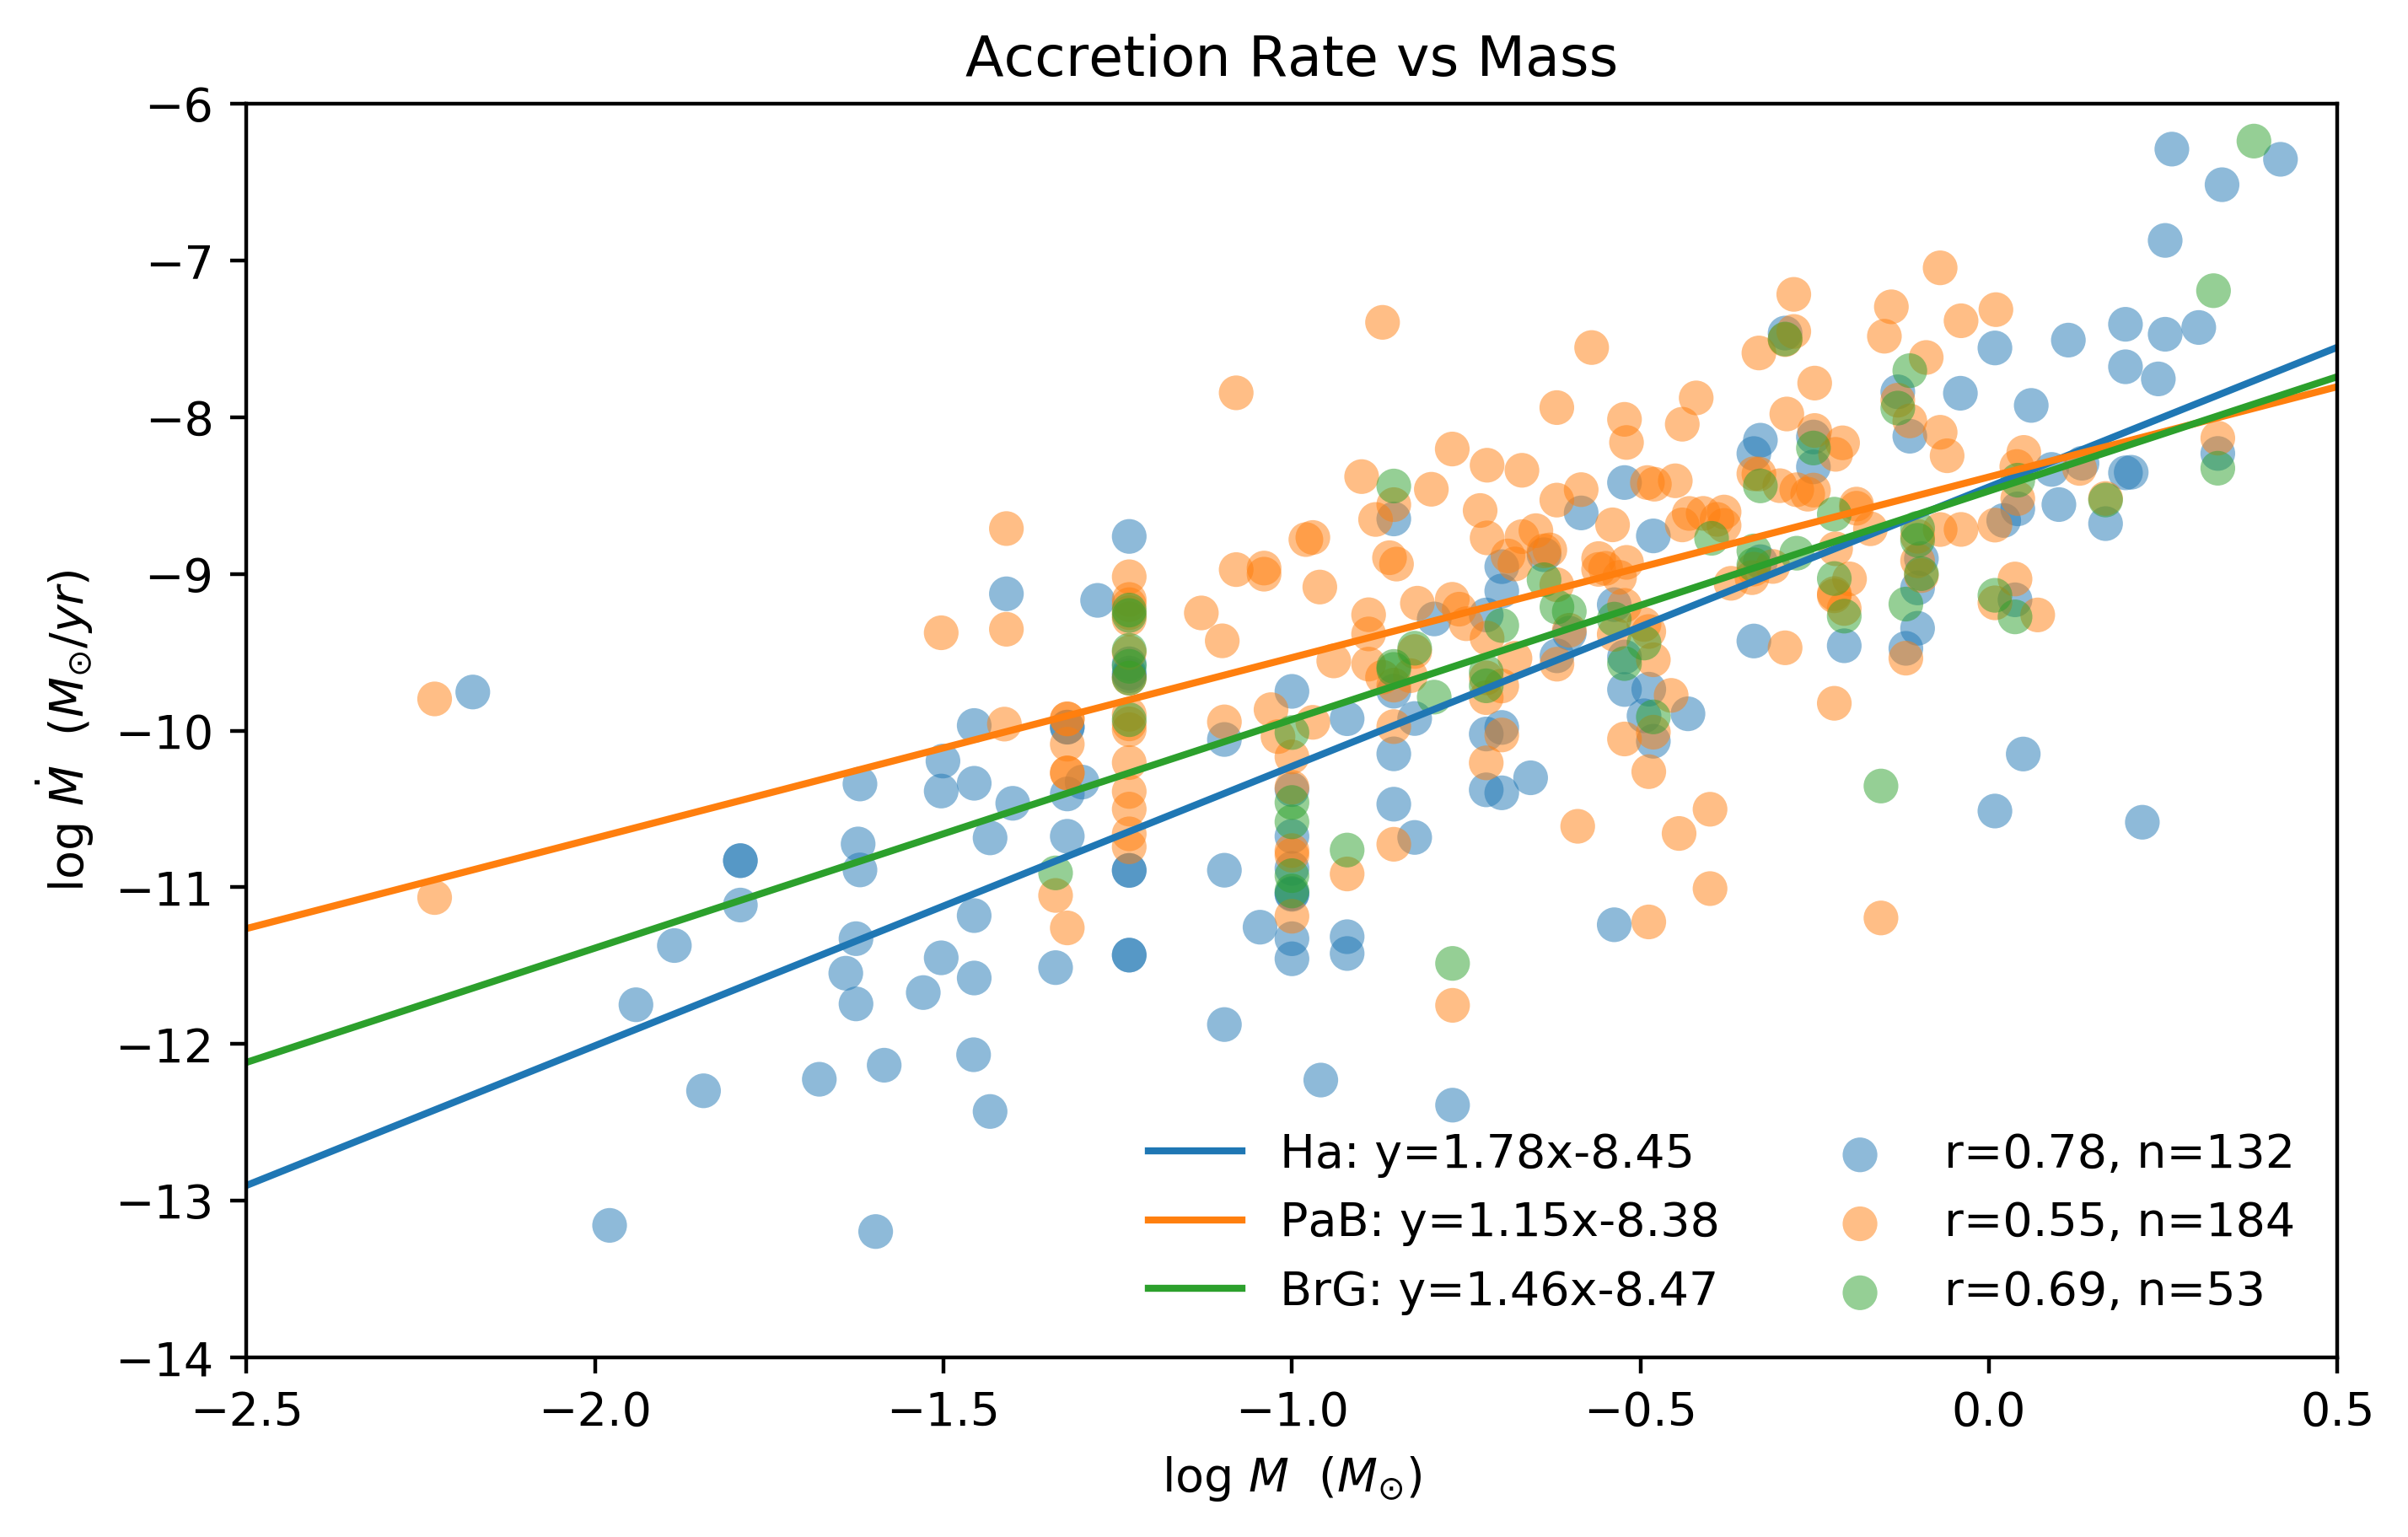

In [28]:
plt.figure(figsize = (8,8/1.625), dpi = 400)

x=arange(-3,2,1)

plt.scatter(m_ha, md_ha, alpha=0.5, 
            label='r='+str(round(r_ha,2))+', n='+str(len(m_ha)), edgecolors='none',s=55)
plt.scatter(m_pab, md_pab, alpha=0.5, 
            label='r='+str(round(r_pab,2))+', n='+str(len(m_pab)), edgecolors='none',s=55)
plt.scatter(m_brg, md_brg, alpha=0.5, 
            label='r='+str(round(r_brg,2))+', n='+str(len(m_brg)), edgecolors='none',s=55)

plt.plot(x, sl_ha*x+incpt_ha,
         label='Ha: y='+str(round(sl_ha,2))+'x'+str(round(incpt_ha,2)))
plt.plot(x, sl_pab*x+incpt_pab,
         label='PaB: y='+str(round(sl_pab,2))+'x'+str(round(incpt_pab,2)))
plt.plot(x, sl_brg*x+incpt_brg,
         label='BrG: y='+str(round(sl_brg,2))+'x'+str(round(incpt_brg,2)))


plt.xlabel('log $M$  $(M_{\odot})$'); plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')
plt.xlim(-2.5,0.5); plt.ylim(-14,-6)
plt.legend(frameon=False,ncol=2); plt.title('Accretion Rate vs Mass') 